# Store images into ES by Base64 Encoding

## Connect to ES

In [2]:
# connect to ES server
from elasticsearch import Elasticsearch
from dotenv import load_dotenv
import os

load_dotenv()

ES_PASSWORD = os.getenv("ES_PASSWORD")
assert ES_PASSWORD, "ES_PASSWORD environment variable not set"

es = Elasticsearch(
    ["https://localhost:9200"],   # list of node URLs
    ca_certs="http_ca.crt",  
    basic_auth=("elastic", ES_PASSWORD)  # if authentication enabled
)

# check connection to ES
if es.ping():
    print("Connected to Elasticsearch!")
else:
    print("Could not connect.")

Connected to Elasticsearch!


## Load and Visualize images

Class name: tench


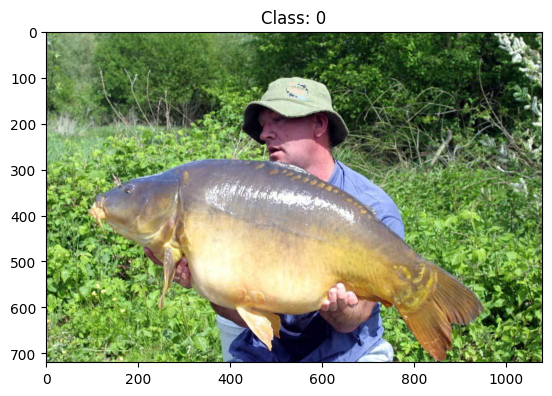

In [ ]:
# load images from hugging face
from datasets import load_dataset

dataset = load_dataset("Elriggs/imagenet-50-subset")

train_dataset = dataset['train']
val_dataset = dataset['validation']

# display a sample image
import matplotlib.pyplot as plt

sample = train_dataset[200]
plt.imshow(sample['image'])
plt.title(f"Class: {sample['label']} - Class name: {sample['class_name']} - WNID: {sample['wnid']}")
plt.show()

In [17]:
type(sample['image'])
print(f"Height: {sample['image'].height} - Width: {sample['image'].width}")

Height: 720 - Width: 1080


current type is PIL.PngImagePlugin.PngImageFile -> change to bytes -> base64 -> store in ES

In [14]:
# store an image into ES
import base64
from io import BytesIO
import PIL

def encode_image_to_base64(image: PIL.JpegImagePlugin.JpegImageFile) -> str:
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_bytes = buffered.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')
    return img_base64

image_base64 = encode_image_to_base64(sample['image'])
print(image_base64[:100])  # print first 100 characters of the base64 string

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx


## Load images into ES

In [20]:
# create index
index_name = "imagenet-50"
es.indices.create(index=index_name, ignore=400)  # ignore 400 already exists

C:\Users\PC\AppData\Local\Temp\ipykernel_22744\3421802127.py:3: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.create(index=index_name, ignore=400)  # ignore 400 already exists


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'imagenet-50'})

In [ ]:
# create upload 100 first images to ES

def load_images_to_es(dataset, es_client, index_name, start=0, num_imgs=100):
    for i in range(start, start + num_imgs):
        sample = dataset[i]
        image_base64 = encode_image_to_base64(sample['image'])
        
        doc = {
            "label": sample['label'],
            "class_name": sample['class_name'],
            "wnid": sample['wnid'],
            "image_base64": image_base64,
            "height": sample['image'].height,
            "width": sample['image'].width,
        }
        
        es_client.index(index=index_name, id=i, document=doc)
        if i % 10 == 0:
            print(f"Indexed {i} images")

In [21]:
load_images_to_es(train_dataset, es, index_name, start=0, num_imgs=100)

Indexed 0 images
Indexed 10 images
Indexed 20 images
Indexed 30 images
Indexed 40 images
Indexed 50 images
Indexed 60 images
Indexed 70 images
Indexed 80 images
Indexed 90 images


## Get images from ES and decode

In [30]:
def decode_base64_to_image(img_base64: str) -> PIL.JpegImagePlugin.JpegImageFile:
    img_bytes = base64.b64decode(img_base64)
    image = PIL.Image.open(BytesIO(img_bytes))
    return image

img_10_response = es.get(index=index_name, id=10)
img_10 = decode_base64_to_image(img_10_response['_source']['image_base64'])

print("img_10 response:", img_10_response)
print("img_10 _source:", img_10_response['_source'])

img_10 response: {'_index': 'imagenet-50', '_id': '10', '_version': 1, '_seq_no': 10, '_primary_term': 1, 'found': True, '_source': {'label': 0, 'class_name': 'tench', 'wnid': 'n01440764', 'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACSAN8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5e

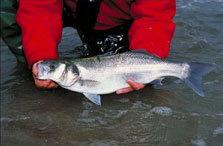

In [31]:
img_10